In [ ]:
# Upload the data
from google.colab import files

uploaded = files.upload()

Saving dineout_data_cleaned_final.csv to dineout_data_cleaned_final.csv


In [ ]:
!pip install tensorflow_text

     |████████████████████████████████| 4.3 MB 7.7 MB/s 


In [ ]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import OrderedDict
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import warnings
warnings.filterwarnings("ignore")
from gensim.summarization.summarizer import summarize
from gensim.summarization import keywords
from sklearn.preprocessing import MultiLabelBinarizer
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
from tensorflow_hub import KerasLayer
import tensorflow_text as text
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, roc_auc_score, accuracy_score, hamming_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier, StackingClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import pickle
import time

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
# Read the csv file
data = pd.read_csv("/content/dineout_data_cleaned_final.csv")

In [ ]:
# Check for null values
data.isnull().sum()

Name               0
Cost_for_2         0
Address           60
About              0
Type               4
Facilities         0
Contact            3
Cuisine            0
Latitude           0
Longitude          0
Stars           1432
Vote_Count         0
Review_Count       0
dtype: int64

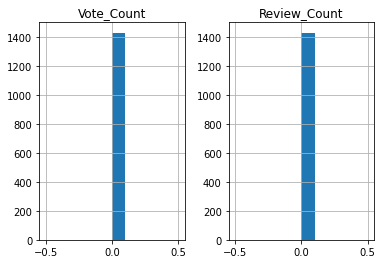

In [ ]:
# Check the distribution of Votes and Reviews where Stars are null

data[data['Stars'].isnull() == True][['Vote_Count', 'Review_Count']].hist()
plt.show()

**Clearly, Stars column has null values where Vote_Count and Review_Count is 0**

In [ ]:
data['Stars'].fillna(0, inplace=True)

In [ ]:
# drop the null values for address
data.dropna(axis=0, inplace=True)

Total number of cuisines in the data is 90



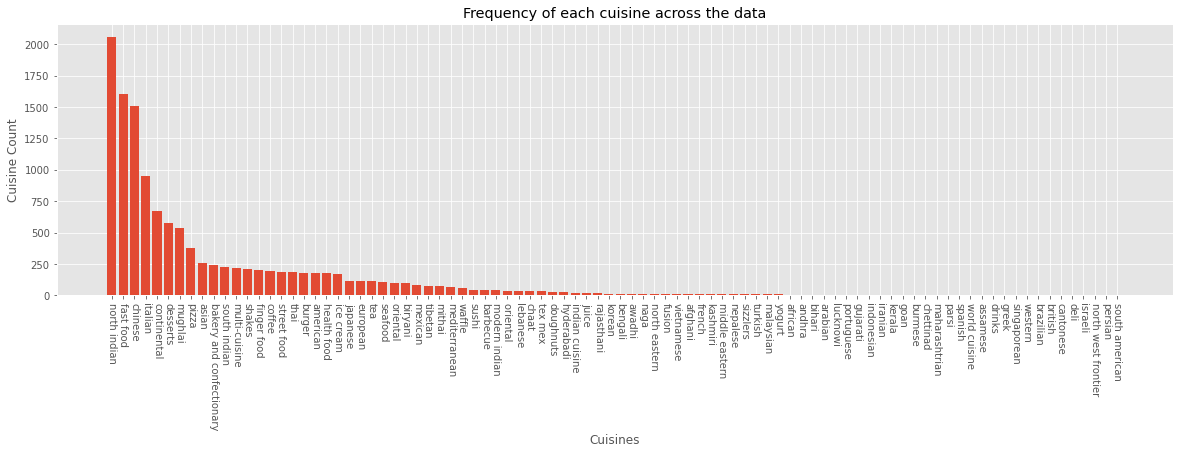

In [ ]:
# Cuisine analysis

# Store all the cuisines in a list
cuisine_list = []
for cuisines in data['Cuisine']:
  for cuisine in cuisines.split(','):
    cuisine_list.append(cuisine.lower()[1:])

# Convert into set for only uniques values
cuisine_set = set(cuisine_list)
print("Total number of cuisines in the data is {}".format(len(cuisine_set)))
print()

# Convert the list into array for visualising the occurence of each cuisin
cuisine_array = np.asarray(cuisine_list)
                           
# Plot the bar chart
labels = np.unique(cuisine_array, return_counts=True)[0]
values = np.unique(cuisine_array, return_counts=True)[1]

# Create a dictionary of the cuisine and its count
cuisine_count = {}
for cuisine, count in zip(labels, values):
  cuisine_count[cuisine] = count

# sort the dictionay bye the key
cuisine_count = OrderedDict(sorted(cuisine_count.items(), key = lambda x : x[1], reverse=True))

plt.figure(figsize=(20,5))
plt.style.use('ggplot')
plt.bar(x=cuisine_count.keys(), height=cuisine_count.values())
plt.xlabel("Cuisines")
plt.ylabel("Cuisine Count")
plt.title("Frequency of each cuisine across the data")
plt.xticks(rotation=-90)
plt.show()

From the above plot it can be inferred that:


1.   North Indian food is most preferred in Delhi-NCR
2.   Fast Food is at the second position.
3.   Chinese cuisine is at the 3rd position.



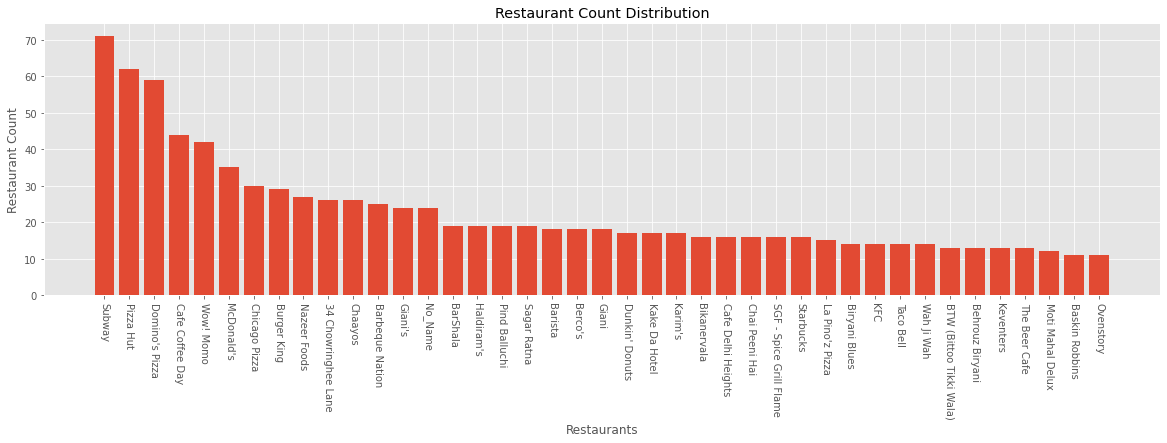

In [ ]:
# Distribution of restaurants across number of outlets

'''Considering only those restaurants which have more than 10 outlets, here I am considering the restaurant count as a proxy for successful business.'''

rest_count = data.groupby('Name').count()['Cost_for_2'].to_dict()
rest_count_sorted = OrderedDict(sorted(dict([(rest, count) for rest, count in rest_count.items() if count > 10]).items(), key=lambda x:x[1], reverse=True))

x = rest_count_sorted.keys()
height = rest_count_sorted.values()

# Plot the bar graph
plt.figure(figsize=(20,5))
plt.bar(x=x, height=height)
plt.xlabel("Restaurants")
plt.ylabel("Restaurant Count")
plt.xticks(rotation=-90)
plt.title("Restaurant Count Distribution")
plt.show()

In [ ]:
# Creating a new feature "Restaurant_Count"
data['Restaurant_Count'] = data['Name'].apply(lambda x : rest_count[x])

# Filter the data with restaurant count > 10
frequent_rest = data[data['Restaurant_Count'] > 10].reset_index().drop('index', axis=1)
others_rest = data[data['Restaurant_Count'] <= 10].reset_index().drop('index', axis=1)

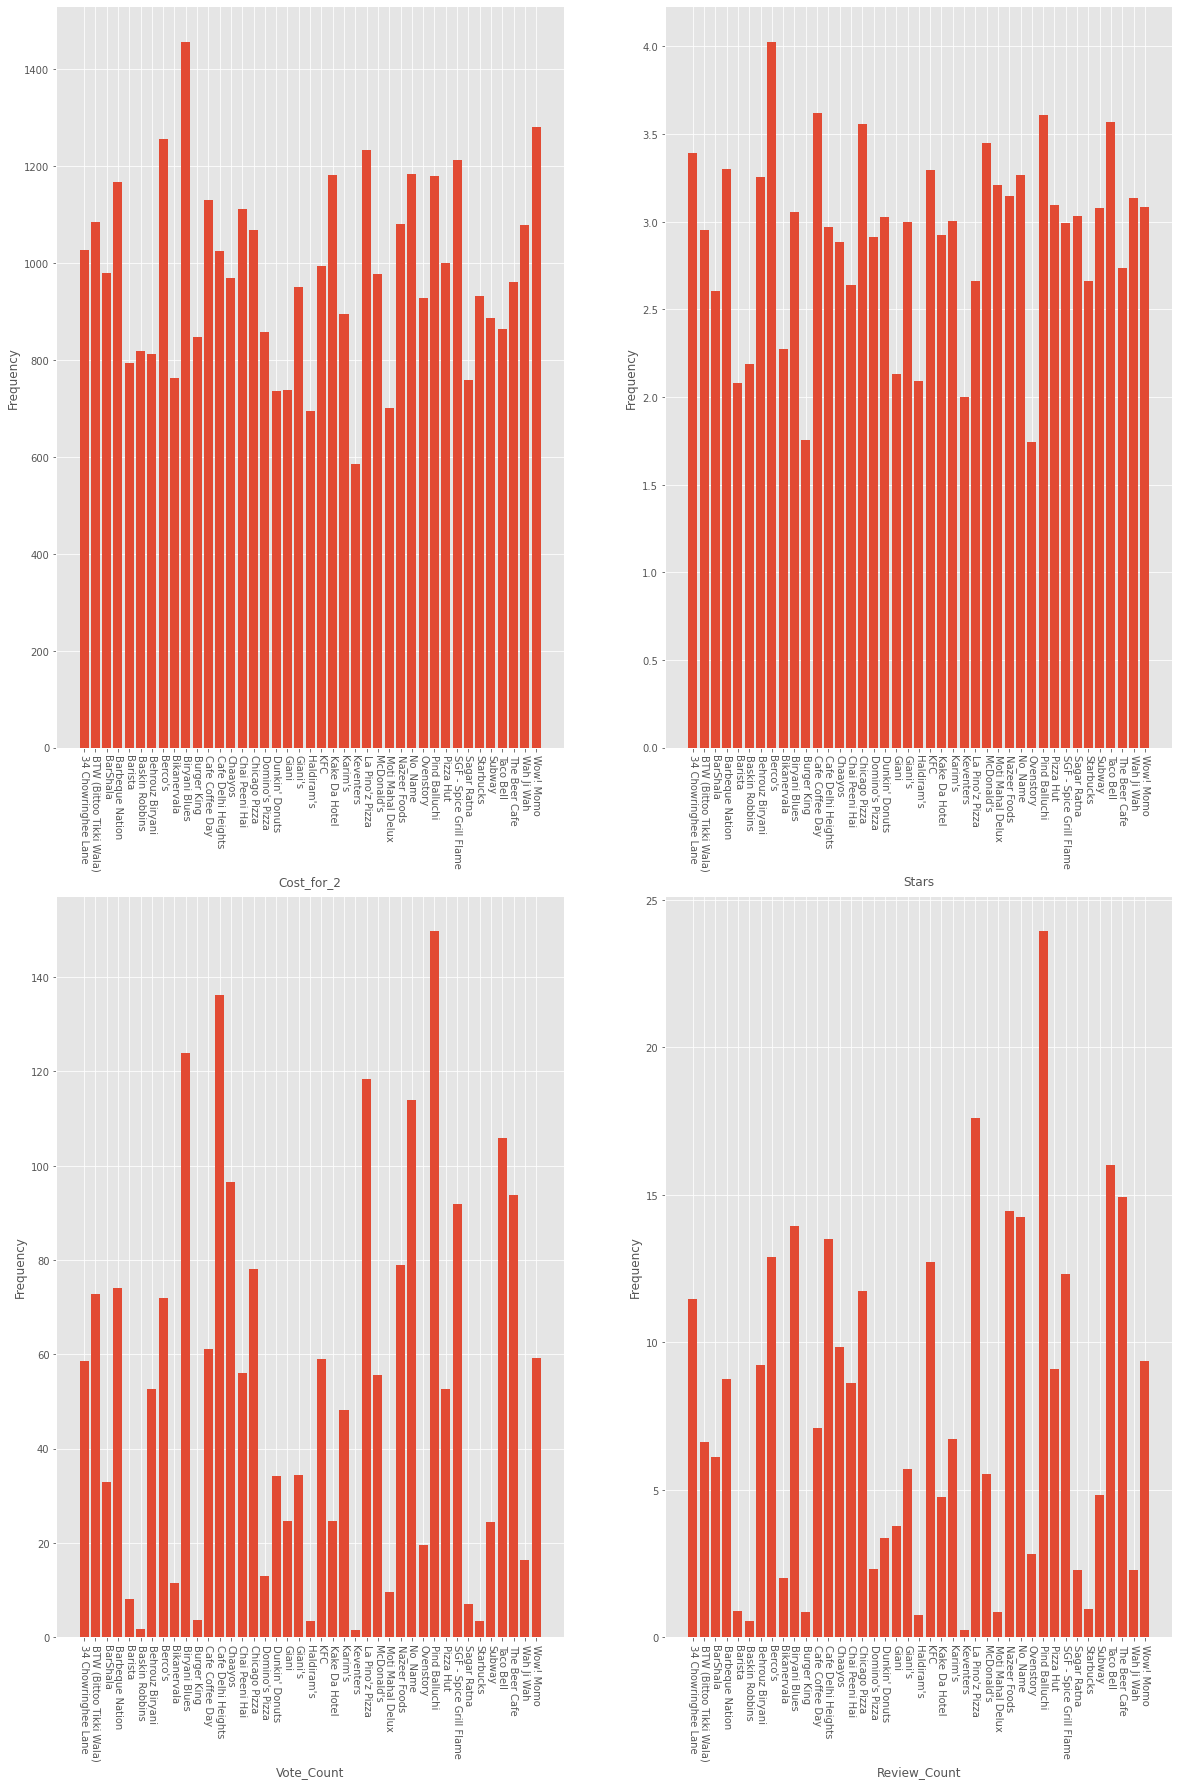

In [ ]:
# Ditribution of average cost for 2, stars, vote count, review_count for restaurants having > 10 outlets
cols_to_consider = ['Cost_for_2', 'Stars', 'Vote_Count', 'Review_Count']

# Group the data by name and take the mean
grouped_data = frequent_rest.groupby('Name').mean()

plt.figure(figsize=(20,30))
for i, col in enumerate(cols_to_consider):
  plt.subplot(2, 2, i+1)
  plt.bar(x=grouped_data[col].index, height=grouped_data[col])
  plt.xlabel(col)
  plt.xticks(rotation=-90)
  plt.ylabel("Frequency")
  #plt.title("Distribution of mean {} for restaurants with >10 outlets".format(col))
plt.show()

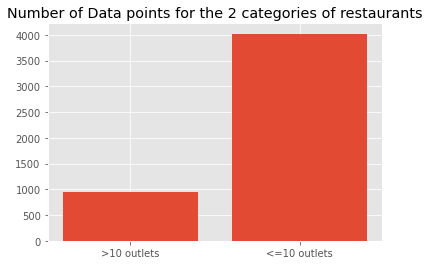

In [ ]:
# Plot the count of the data points for both categories of the data

h1 = frequent_rest.shape[0]
h2 = others_rest.shape[0]

plt.bar(x = ['>10 outlets', '<=10 outlets'], height = [h1, h2])
plt.title("Number of Data points for the 2 categories of restaurants")
plt.show()

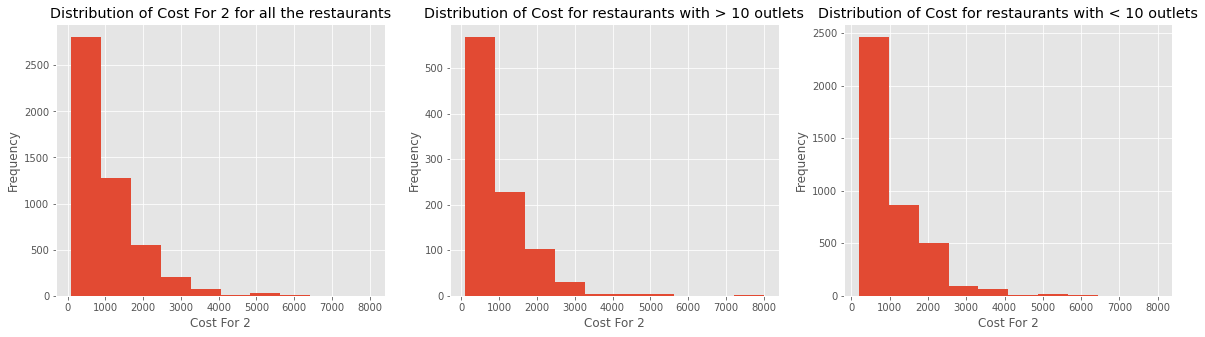

In [ ]:
'''
Next, a comparison is done w.r.t Cost_for_2, stars, vote count, review count accross all the restaurants 
and those restaurant with more than 10 outlets and the restaurants having less than 10 outlets
'''

# 1. Cost for 2
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

ax[0].hist(data['Cost_for_2'])
ax[0].set_xlabel("Cost For 2")
ax[0].set_ylabel("Frequency")
ax[0].set_title("Distribution of Cost For 2 for all the restaurants")

ax[1].hist(frequent_rest['Cost_for_2'])
ax[1].set_xlabel("Cost For 2")
ax[1].set_ylabel("Frequency")
ax[1].set_title("Distribution of Cost for restaurants with > 10 outlets")

ax[2].hist(others_rest['Cost_for_2'])
ax[2].set_xlabel("Cost For 2")
ax[2].set_ylabel("Frequency")
ax[2].set_title("Distribution of Cost for restaurants with < 10 outlets")

fig.show()

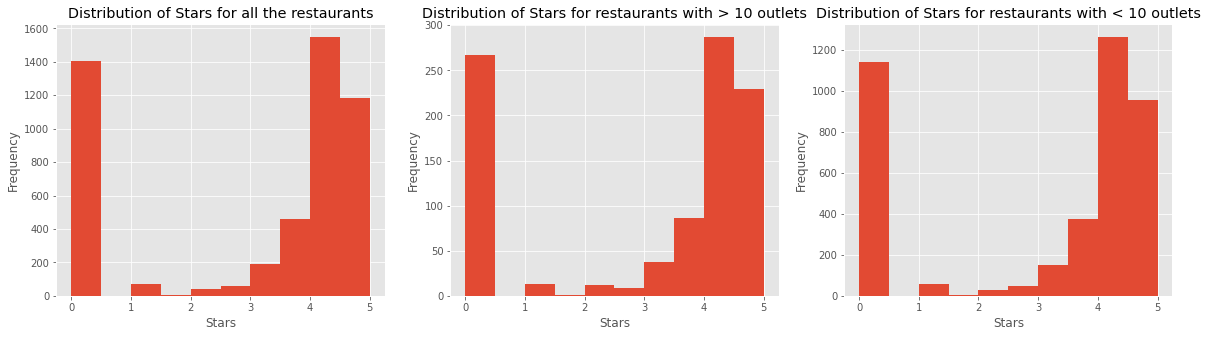

In [ ]:
# 2. Stars
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

ax[0].hist(data['Stars'])
ax[0].set_xlabel("Stars")
ax[0].set_ylabel("Frequency")
ax[0].set_title("Distribution of Stars for all the restaurants")

ax[1].hist(frequent_rest['Stars'])
ax[1].set_xlabel("Stars")
ax[1].set_ylabel("Frequency")
ax[1].set_title("Distribution of Stars for restaurants with > 10 outlets")

ax[2].hist(others_rest['Stars'])
ax[2].set_xlabel("Stars")
ax[2].set_ylabel("Frequency")
ax[2].set_title("Distribution of Stars for restaurants with < 10 outlets")

fig.show()

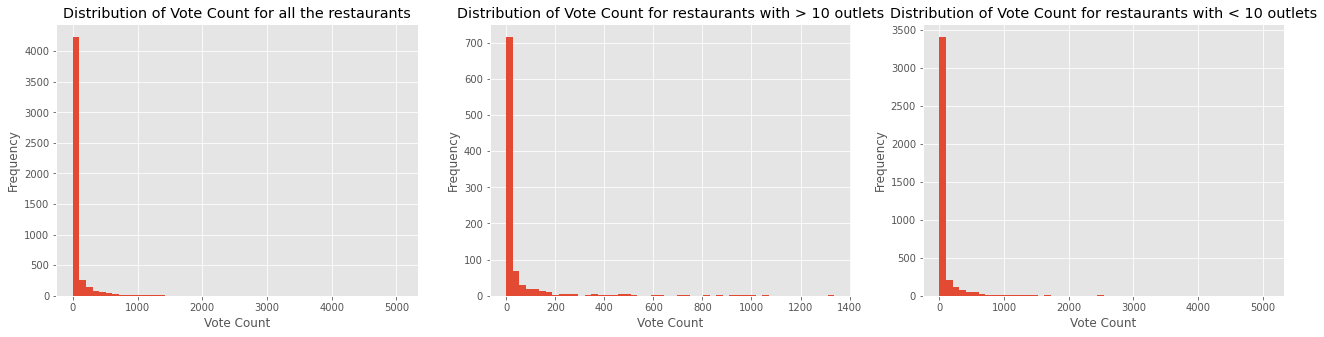

In [ ]:
# 3. Vote_Count
fig, ax = plt.subplots(1, 3, figsize=(22, 5))

ax[0].hist(data['Vote_Count'], bins=50)
ax[0].set_xlabel("Vote Count")
ax[0].set_ylabel("Frequency")
ax[0].set_title("Distribution of Vote Count for all the restaurants")

ax[1].hist(frequent_rest['Vote_Count'], bins=50)
ax[1].set_xlabel("Vote Count")
ax[1].set_ylabel("Frequency")
ax[1].set_title("Distribution of Vote Count for restaurants with > 10 outlets")

ax[2].hist(others_rest['Vote_Count'], bins=50)
ax[2].set_xlabel("Vote Count")
ax[2].set_ylabel("Frequency")
ax[2].set_title("Distribution of Vote Count for restaurants with < 10 outlets")

fig.show()

**A similar distribution for all the columns can be observed for all the 3 categories.**

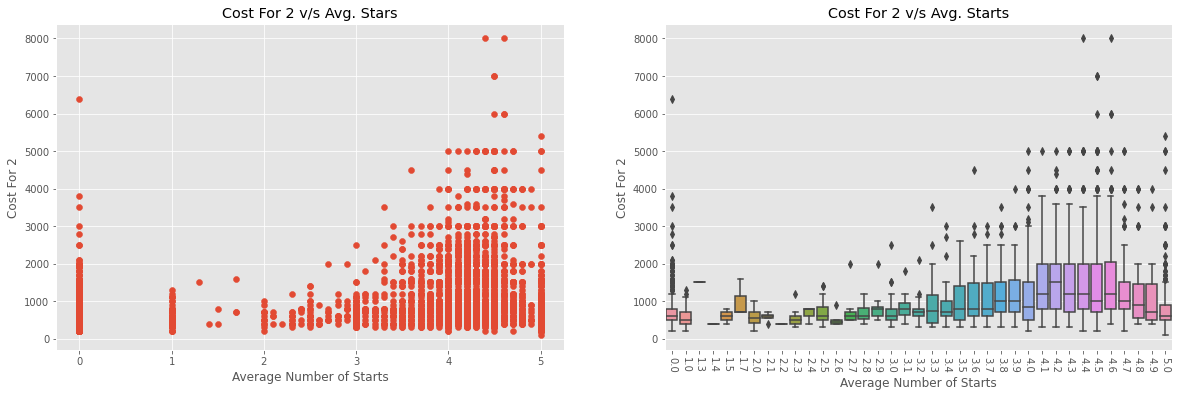

In [ ]:
# Relation between stars and the cost for 2
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

ax[0].scatter(x=data['Stars'], y=data['Cost_for_2'])
ax[0].set_xlabel("Average Number of Starts")
ax[0].set_ylabel("Cost For 2")
ax[0].set_title("Cost For 2 v/s Avg. Stars")

sns.boxplot(data=data, x='Stars', y='Cost_for_2', ax=ax[1])
plt.xlabel("Average Number of Starts")
plt.xticks(rotation=-90)
plt.ylabel("Cost For 2")
plt.title("Cost For 2 v/s Avg. Starts")
plt.show()

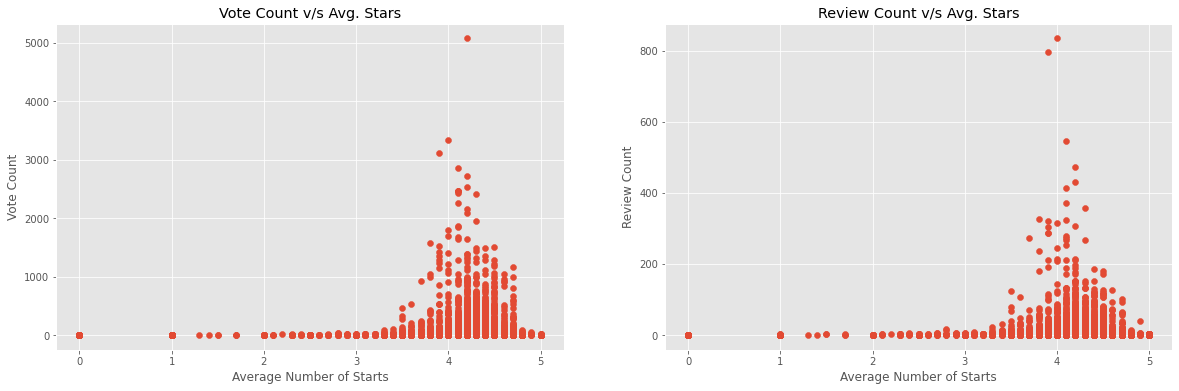

In [ ]:
# Relation between stars and the vote count
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

ax[0].scatter(x=data['Stars'], y=data['Vote_Count'])
ax[0].set_xlabel("Average Number of Starts")
ax[0].set_ylabel("Vote Count")
ax[0].set_title("Vote Count v/s Avg. Stars")

# Relation between stars and the Review count
ax[1].scatter(x=data['Stars'], y=data['Review_Count'])
ax[1].set_xlabel("Average Number of Starts")
ax[1].set_ylabel("Review Count")
ax[1].set_title("Review Count v/s Avg. Stars")

fig.show()



*   Restaurants having average stars between 4.1 and 4.5 have higher median and maximum cost for 2.
*   Cost for 2 increases initially with increase in stars but then dip in cost can be observed with further increase in average number of stars.



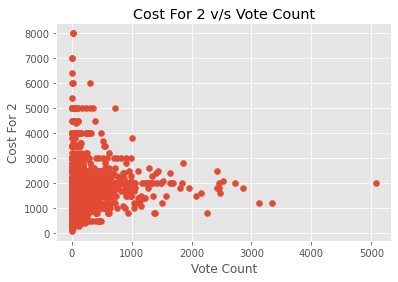

In [ ]:
# Vote Count v/s Cost_for_2
plt.scatter(x=data['Vote_Count'], y=data['Cost_for_2'])
plt.xlabel("Vote Count")
plt.ylabel("Cost For 2")
plt.title("Cost For 2 v/s Vote Count")
plt.show()

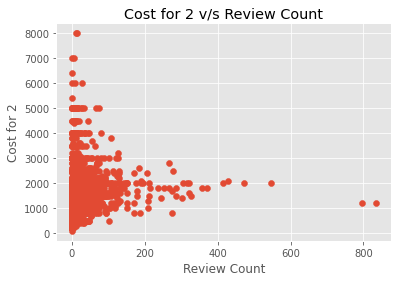

In [ ]:
# Variation of review count with cost for 2
plt.scatter(data['Review_Count'], data['Cost_for_2'])
plt.xlabel("Review Count")
plt.ylabel("Cost for 2")
plt.title("Cost for 2 v/s Review Count")
plt.show()

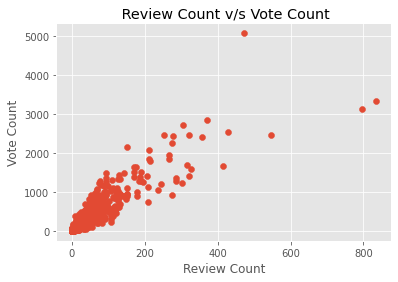

In [ ]:
# Variation of review count with vote count
plt.scatter(data['Review_Count'], data['Vote_Count'])
plt.xlabel("Review Count")
plt.ylabel("Vote Count")
plt.title(" Review Count v/s Vote Count")
plt.show()

**Approximate Linear Relation can be observed between the Value Count and Review Count.**

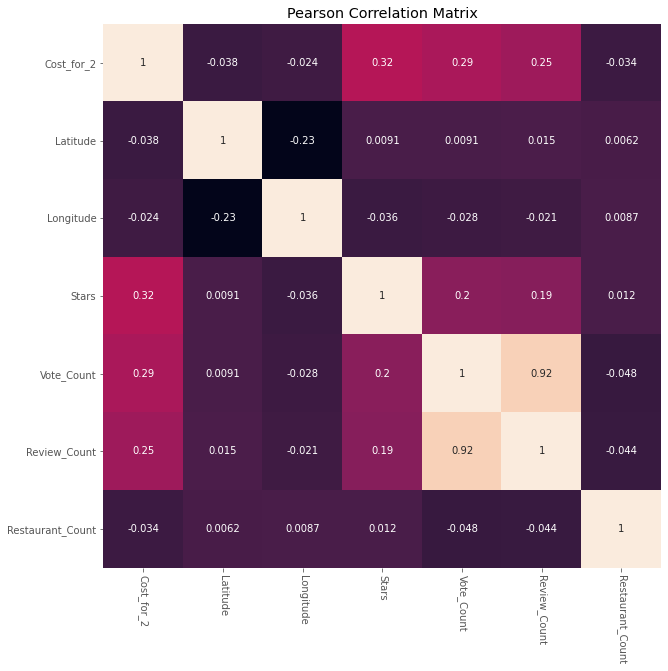

In [ ]:
# Plot the heatmap of Pearson Correlation matrix to quantify the same
corr_matrix = data.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix, annot=True, cbar=False)
plt.xticks(rotation=-90)
plt.yticks(rotation=0)
plt.title("Pearson Correlation Matrix")
plt.show()

In [ ]:
# Extract Pincode from address
def extract_pincode(x):

  try:
    pincode = int(x[-6:])
  except:
    pincode = np.nan
  
  return pincode
data['Pincode'] = data['Address'].apply(lambda x : extract_pincode(x))

In [ ]:
data[data['Pincode'].isnull() == True]

,Name,Cost_for_2,Address,About,Type,Facilities,Contact,Cuisine,Latitude,Longitude,Stars,Vote_Count,Review_Count,Restaurant_Count,Pincode
3958,Taxi Bar & Cafe,1100,"Shop 1, Ground Floor, M 74, Jagat Ram Park Lax...",No_About,QSR,['Delivery Only'],09818450028,"Fast Food, Burger",28.634789,77.277718,0.0,0,0,1,NaN
4420,Jacky Ching,500,"Shop 3, Ground Floor, DDA Mini Market, Hudson ...",No_About,"Cafe, Opening Soon","['Cards Accepted', 'Wallet Accepted']",09899640202,Fast Food,28.694641,77.204987,0.0,0,0,9,NaN


**Only 2 indexes have null values.**

We can use google to extract the pincode for these 2 locations

In [ ]:
address1 = data[data['Pincode'].isnull() == True]['Address'].iloc[0]
address2 = data[data['Pincode'].isnull() == True]['Address'].iloc[1]



1.   Pincode for address 1 is 110092
2.   Pincdoe for address 2 is 110009

Source: Google


In [ ]:
# fill the null values
null_indexes = list(data[data['Pincode'].isnull() == True].index)
values = [110092, 110009]

for idx, val in zip(null_indexes, values):
  data.at[idx, 'Pincode'] = val

In [ ]:
data['Pincode'] = data['Pincode'].astype('str')

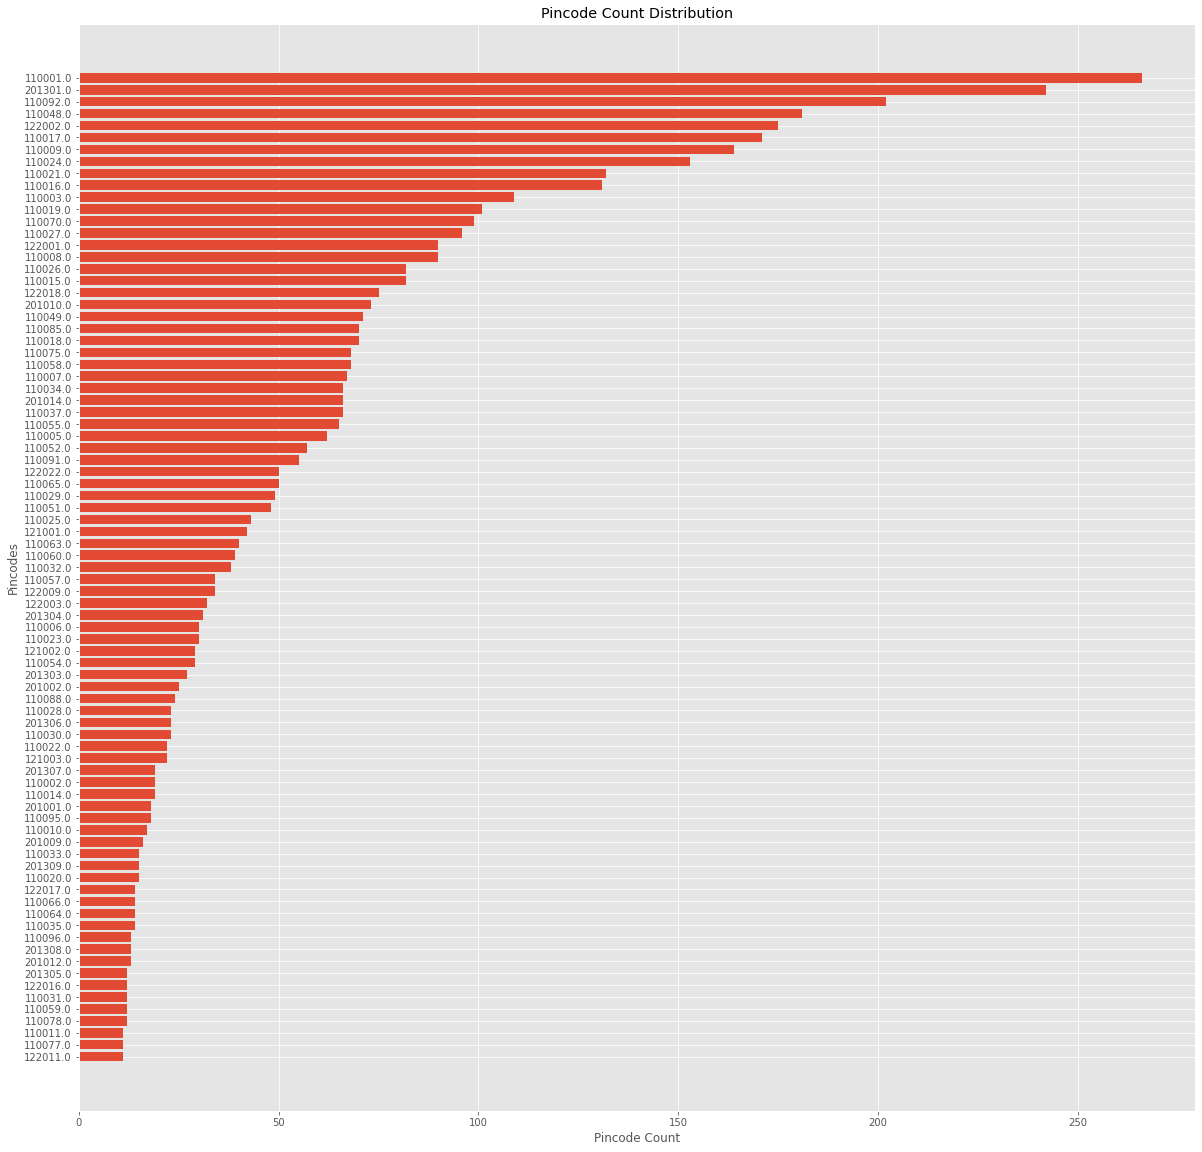

In [ ]:
# Visualise the distribution of pincode
pincode_count = OrderedDict(sorted(dict(data['Pincode'].value_counts()).items(), key=lambda x : x[1], reverse=False))
pincode_count_10 = {pc : count for (pc, count) in pincode_count.items() if count > 10}

# plot the bar graph
plt.figure(figsize=(20, 20))
y = pincode_count_10.keys()
width = pincode_count_10.values()

plt.barh(y=[*pincode_count_10], width=width)
plt.xlabel("Pincode Count")
plt.ylabel("Pincodes")
plt.title("Pincode Count Distribution")
plt.show()

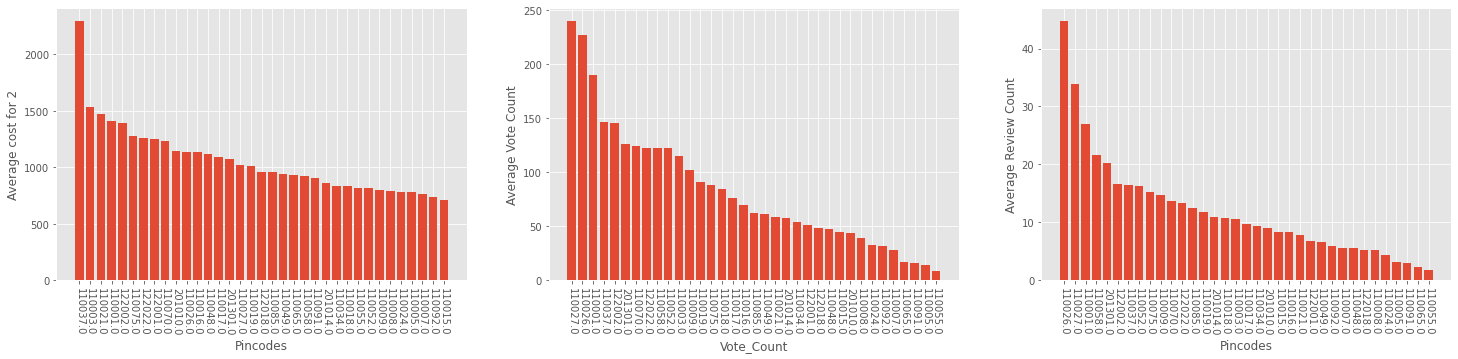

In [ ]:
# pincode wise distribution of Cost for 2

# Create a column called pincode count and extract only the data for those pincodes having more than 50 occurrences
data['Pincode_Count'] = data['Pincode'].apply(lambda x : pincode_count[x])
top_pincodes = data[data['Pincode_Count'] >= 50]

# Group the data by Pincodes and plot the Mean and Median stats for Cost for 2, Stars, Vote Count, Review Count
grouped_mean_data = top_pincodes.groupby('Pincode').mean()

x = grouped_mean_data.sort_values(by='Cost_for_2', ascending=False).index
height = grouped_mean_data.sort_values(by='Cost_for_2', ascending=False)['Cost_for_2']

fig, ax = plt.subplots(1, 3, figsize=(25, 5))
ax[0].bar(x=x, height=height)
ax[0].set_xlabel("Pincodes")
ax[0].set_ylabel("Average cost for 2")
ax[0].tick_params(rotation=-90, axis='x')

x = grouped_mean_data.sort_values(by='Vote_Count', ascending=False).index
height = grouped_mean_data.sort_values(by='Vote_Count', ascending=False)['Vote_Count']

ax[1].bar(x=x, height=height)
ax[1].set_xlabel("Vote_Count")
ax[1].set_ylabel("Average Vote Count")
ax[1].tick_params(rotation=-90, axis='x')

x = grouped_mean_data.sort_values(by='Review_Count', ascending=False).index
height = grouped_mean_data.sort_values(by='Review_Count', ascending=False)['Review_Count']

ax[2].bar(x=x, height=height)
ax[2].set_xlabel("Pincodes")
ax[2].set_ylabel("Average Review Count")
ax[2].tick_params(rotation=-90, axis='x')

fig.show()

In [ ]:
# Keyword analytics

'''
Next we extract keywords using Bag of words Pipeline from About, Type, Facilities, and Cuisine Columns.
'''

def preprocess_facilites(x):
  string_list = re.sub(r'[\([{})\'\'\]]', '',x).split(',')
  string_list_final = []
  for string in string_list:
    string_list_final.append(string.lstrip())
  return string_list_final

data['Facilities'] = data['Facilities'].apply(lambda x : preprocess_facilites(x))

facility_list = []
for facilities in data['Facilities']:
  for facility in facilities:
    facility_list.append(facility)

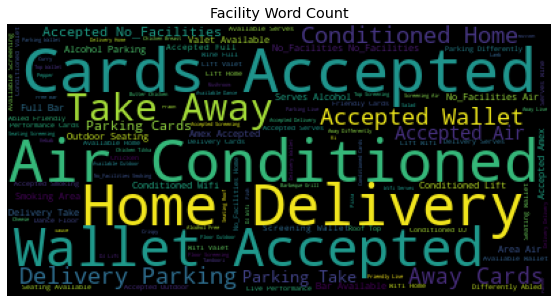

In [ ]:
# Generate wordcloud
wordcloud_facility = WordCloud().generate(" ".join(facility_list))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_facility)
plt.axis('off')
plt.title("Facility Word Count")
plt.show()

In [ ]:
facility_count = {}

for (facility, count) in zip(np.unique(facility_list, return_counts=True)[0], np.unique(facility_list, return_counts=True)[1]):
  facility_count[facility] = count

facility_count_10 = OrderedDict(sorted({k : v for k,v in facility_count.items() if v > 10}.items(), key = lambda x : x[1], reverse=True))

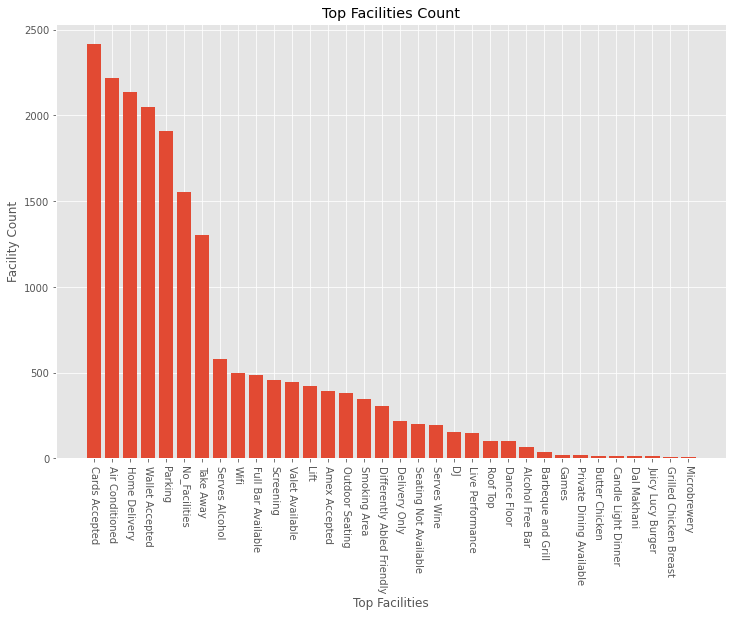

In [ ]:
x = facility_count_10.keys()
height = facility_count_10.values()

# Plot the bar graph for most frequent facilities
plt.figure(figsize=(12,8))
plt.bar(x=x, height=height)
plt.xlabel("Top Facilities")
plt.ylabel("Facility Count")
plt.title("Top Facilities Count")
plt.xticks(rotation=-90)
plt.show()

In [ ]:
# Extract only the text data
text_data = data[['Name', 'About', 'Type', 'Facilities', 'Cuisine']]

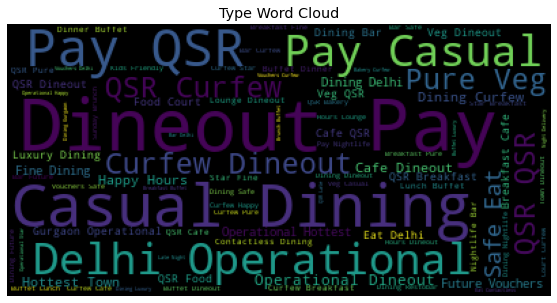

In [ ]:
# word cloud analysis of the Type feature
def preprocess_type(x):

  type_list = x.split(',')
  final_type_list = []
  for word in type_list:
    final_type_list.append(word.lstrip())

  return final_type_list

text_data['Type'] = text_data['Type'].apply(lambda x : preprocess_type(x))

# Create a list of keywords
type_list = []
for types in text_data['Type']:
  for type_ in types:
    type_list.append(type_)

# Create a wordcloud

wordcloud_type = WordCloud().generate(" ".join(type_list))
plt.figure(figsize=(10,5))
plt.imshow(wordcloud_type)
plt.axis('off')
plt.title("Type Word Cloud")
plt.show()

In [ ]:
# keyword extraction in About Feature

sw = stopwords.words('english')

def preprocess_text(x, remove_noise=False, remove_symbols=False, noise=None):

  # Convert in lower_case
  x = x.lower()

  if remove_symbols:
    x = re.sub(r'[^\w]', ' ', x)

  # tokenize the data
  tokenized_sentence = word_tokenize(x)

  # Remove the noise
  if remove_noise:
    try:

      for i in range(len(noise)):
        tokenized_sentence.remove(noise[i]) # noise in this case is no_about, no_facilities etc.
      tokenized_sentence.remove('read le')
      tokenized_sentence.remove('read less')
    except:
      pass

  # Stopword removal
  clean_sentence = [word for word in tokenized_sentence if word not in sw]

  # lemmatizing
  lemmatizer_object = WordNetLemmatizer()
  lemmatized_sentence = [lemmatizer_object.lemmatize(word) for word in clean_sentence]

  final_text = " ".join(lemmatized_sentence)
  return final_text

clean_text = text_data['About'].apply(lambda x : preprocess_text(x, remove_noise=True, noise=['no_about'])).values.tolist()

In [ ]:
# Remove duplicates and space
clean_text = list(filter(None,clean_text))

In [ ]:
clean_text_string = " ".join(clean_text)

In [ ]:
len(clean_text_string)

1178676

In [ ]:
# Extract minimum 10 keywords from every 200 words
about_keywords = []
i = 0
while (i  < len(clean_text_string)) and (i+200 < len(clean_text_string)):
  top_keywords = keywords(clean_text_string[i :200+i], words=10)
  about_keywords.append(top_keywords)
  i = i + 200

In [ ]:
# Store the keywords in a file
with open("about_keywords.txt","w") as f:
  f.write(" ".join(about_keywords))
f.close()

# Cuisine Classification

In [ ]:
# Prepare data for modelling
clf_data = data[['Name', 'About', 'Type', 'Facilities', 'Cuisine']]

In [ ]:
# Preprocess the target variable, convert the strings into lower case, split on the basis of , and strip the first space
def preprocess_cuisine(x):
  cuisine = x.split(',')
  cuisine_list = []
  for c in cuisine:
    c = c.lstrip()
    cuisine_list.append(c.lower())
  return cuisine_list

# Apply the above fn
clf_data['Cuisine'] = clf_data['Cuisine'].apply(lambda x : preprocess_cuisine(x))

In [ ]:
# Prepare the target variable with MultiLabelBinarizer

# MultiLabelBinarizer Object
mlb = MultiLabelBinarizer()
targets = mlb.fit_transform(clf_data['Cuisine'])

In [ ]:
clf_data['Facilities'] = clf_data['Facilities'].apply(lambda x : ", ".join(x))

In [ ]:
text_data_clf = clf_data['Name'] + ' ' + clf_data['About'] + ' ' + clf_data['Type'] + ' ' + clf_data['Facilities'] 

In [ ]:
text_data_cleaned = text_data_clf.apply(lambda x : preprocess_text(x, remove_noise=True, remove_symbols=True, noise=['no_about', 'no_type', 'no_facilities', 'no_facility']))

In [ ]:
text_data_cleaned = text_data_cleaned.apply(lambda x : x.replace('read le', ''))

## Machine Learning Models

In [ ]:
# Convert into vectors using tfidf
tfidf = TfidfVectorizer()

# Create vectors
word_vectors = tfidf.fit_transform(text_data_cleaned)

In [ ]:
# Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(word_vectors, targets, test_size=0.2, random_state=42)

In [ ]:
# Compute metrics
def compute_metrics(y_true, y_pred, model_name):

  # 1. Accuracy score
  acc = accuracy_score(y_true, y_pred)

  # 2. Precision (Micro Average)
  prec_micro = precision_score(y_true, y_pred, average='micro')

  # 3. Precision (Macro Average)
  prec_macro = precision_score(y_true, y_pred, average='macro')

  # 4. Recall (Micro Average)
  rec_micro = recall_score(y_true, y_pred, average='micro')

  # 5. Recall (Micro Average)
  rec_macro = recall_score(y_true, y_pred, average='macro')

  # 6. f1 score (Micro)
  f1_micro = f1_score(y_true, y_pred, average='micro')

  # 7. f1 score (Macro)
  f1_macro = f1_score(y_true, y_pred, average='macro')

  # Return micro and macro metrics
  micro_metrics = {'Accuracy_Score' : acc,
                   'Precision_Micro' : prec_micro,
                   'Recall_Micro' : rec_micro,
                   'f1_Micro': f1_micro
                  }
  # Convert into dataframe
  micro_metrics_df = pd.DataFrame(micro_metrics, index = [model_name])

  macro_metrics = {'Accuracy_Score': acc,
                   'Precision_Macro' : prec_macro,
                   'Recall_Macro' : rec_macro,
                   'f1_Macro' : f1_macro
                   }
  # Convert into dataframe
  macro_metrics_df = pd.DataFrame(macro_metrics, index = [model_name])

  return micro_metrics_df, macro_metrics_df
# Build Models
def build_models(X_train, X_test, y_train, y_test):

  # Prepare a model dictionary
  models = {"LogisticRegression" : LogisticRegression(),
            "NaiveBayes" : MultinomialNB(),
            "DecisionTree" : DecisionTreeClassifier(),
            "RandomForest" :  RandomForestClassifier(),
            "ExtraTrees" : ExtraTreesClassifier(),
            "XGBoost" : XGBClassifier(),
            "LightGBM" : LGBMClassifier()
            }

  # Create a dataframe for storing results
  train_micro_metrics = pd.DataFrame()
  train_macro_metrics = pd.DataFrame()
  test_micro_metrics = pd.DataFrame()
  test_macro_metrics = pd.DataFrame()

  for model_name, model in models.items():
    
    # Fit the model in oneVSrest Classifier
    start_time = time.time()
    clf = OneVsRestClassifier(model, n_jobs=-1).fit(X_train, y_train)
    print("Building {} Model".format(model_name))

    # Compute metrics
    train_prediction = clf.predict(X_train)
    test_prediction = clf.predict(X_test)

    micro_metrics_train, macro_metrics_train = compute_metrcis(y_train, train_prediction, model_name)
    micro_metrics_test, macro_metrics_test = compute_metrics(y_test, test_prediction, model_name)

    # Store the training metrics
    train_micro_metrics = pd.concat((train_micro_metrics, micro_metrics_train))
    train_macro_metrics = pd.concat((train_macro_metrics, macro_metrics_train))

    # Store the testing metrics
    test_micro_metrics = pd.concat((test_micro_metrics, micro_metrics_test))
    test_macro_metrics = pd.concat((test_macro_metrics, macro_metrics_test))

    end_time = time.time()
    print("{} Model Built".format(model_name))
    print("Total time taken {:.3f} seconds".format(end_time-start_time))
    print()

  return train_micro_metrics, train_macro_metrics, test_micro_metrics, test_macro_metrics

In [ ]:
# Call the function
train_micro_metrics, train_macro_metrics, test_micro_metrics, test_macro_metrics = build_models(X_train, X_test, y_train, y_test)

Building LogisticRegression Model
LogisticRegression Model Built
Total time taken 3.417 seconds

Building NaiveBayes Model
NaiveBayes Model Built
Total time taken 1.038 seconds

Building DecisionTree Model
DecisionTree Model Built
Total time taken 21.049 seconds

Building RandomForest Model
RandomForest Model Built
Total time taken 89.420 seconds

Building ExtraTrees Model
ExtraTrees Model Built
Total time taken 164.214 seconds

Building XGBoost Model
XGBoost Model Built
Total time taken 160.096 seconds

Building LightGBM Model
LightGBM Model Built
Total time taken 131.622 seconds



In [ ]:
test_micro_metrics = test_micro_metrics.add_suffix('_Test')

In [ ]:
train_micro_metrics = train_micro_metrics.add_suffix('_Train')

In [ ]:
# Concat the train and test metrics
model_metrics = pd.concat((train_micro_metrics, test_micro_metrics), axis=1).sort_values(by=['f1_Micro_Test','Precision_Micro_Test'], ascending=False)

In [ ]:
model_metrics[['f1_Micro_Train', 'f1_Micro_Test']]

,f1_Micro_Train,f1_Micro_Test
XGBoost,0.736582,0.652174
LightGBM,0.933169,0.651584
DecisionTree,0.996644,0.591853
RandomForest,0.996546,0.537354
LogisticRegression,0.591636,0.535334
ExtraTrees,0.996644,0.532713
NaiveBayes,0.311686,0.239893


In [ ]:
model_metrics[['Precision_Micro_Train', 'Precision_Micro_Test']]

,Precision_Micro_Train,Precision_Micro_Test
XGBoost,0.931582,0.853581
LightGBM,0.959397,0.761905
DecisionTree,0.999899,0.610504
RandomForest,0.999097,0.859253
LogisticRegression,0.905536,0.864317
ExtraTrees,0.999899,0.866429
NaiveBayes,0.920176,0.775378


### Hyperparameter Tuning



ExtraTrees Classifier



In [ ]:
# 1. ExtraTrees Classifier

# set parameters
params = {'n_estimators' : [50, 100, 150, 200, 250, 300, 500, 1000],
          'criterion' : ['ginin', 'entropy'],
          'max_depth' : [None, 10, 30, 50, 70, 100, 200, 500],
          'min_samples_split' : [2, 3, 4, 5, 6, 7, 8, 9, 10],
          'min_samples_leaf' : [1, 3, 5, 7, 9],
          'min_weight_fraction_leaf' : np.arange(0, 1, 0.2, dtype='float'),
          'max_features' : ["auto", "sqrt", "log2"],
          'bootstrap' : [True, False],
          'oob_score' : [True, False]
          }

# Default Model Object
ext_trees_clf = ExtraTreesClassifier()

# Randomized Search CV
rscv_ext_clf = RandomizedSearchCV(ext_trees_clf, param_distributions=params, n_iter=100, scoring='f1_micro', n_jobs=-1, cv=3, verbose=4, random_state=42)

# Fit the model
rscv_ext_clf.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 217 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  9.0min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=ExtraTreesClassifier(bootstrap=False,
                                                  ccp_alpha=0.0,
                                                  class_weight=None,
                                                  criterion='gini',
                                                  max_depth=None,
                                                  max_features='auto',
                                                  max_leaf_nodes=None,
                                                  max_samples=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                        

In [ ]:
# Extract the best estimator
ext_best_clf = rscv_ext_clf.best_estimator_

# Make Predictions
rscv_pred_ext_train = ext_best_clf.predict(X_train)
rscv_pred_ext_test = ext_best_clf.predict(X_test)

# Compute Metrics
micro_metrics_rscv_df_train, macro_metrics_rscv_df_train = compute_metrics(y_train, rscv_pred_ext_train, "ExtraTrees_Best")
micro_metrics_rscv_df_test, macro_metrics_rscv_df_test = compute_metrics(y_test, rscv_pred_ext_test, "ExtraTrees_Best")

In [ ]:
# Concat the metrics
micro_metrics_rscv_df_train = micro_metrics_rscv_df_train.add_suffix('_Train')
micro_metrics_rscv_df_test = micro_metrics_rscv_df_test.add_suffix('_Test')
ht_model_metrics = pd.concat((micro_metrics_rscv_df_train, micro_metrics_rscv_df_test), axis=1).sort_values(by=['f1_Micro_Test', 'Precision_Micro_Test'], ascending=False)

In [ ]:
# Merge the default scores and the tuned model
model_metrics = pd.concat((model_metrics, ht_model_metrics), axis=0).sort_values(by = ['f1_Micro_Test', 'Precision_Micro_Test'], ascending=False)

,Accuracy_Score_Train,Precision_Micro_Train,Recall_Micro_Train,f1_Micro_Train,Accuracy_Score_Test,Precision_Micro_Test,Recall_Micro_Test,f1_Micro_Test
XGBoost,0.424288,0.931582,0.609086,0.736582,0.317221,0.853581,0.527668,0.652174
LightGBM,0.777778,0.959397,0.908337,0.933169,0.312185,0.761905,0.569170,0.651584
DecisionTree,0.990426,0.999899,0.993410,0.996644,0.217523,0.610504,0.574308,0.591853
RandomForest,0.990426,0.999097,0.994009,0.996546,0.223565,0.859253,0.390909,0.537354
LogisticRegression,0.244898,0.905536,0.439341,0.591636,0.194361,0.864317,0.387747,0.535334
ExtraTrees,0.990426,0.999899,0.993410,0.996644,0.231621,0.866429,0.384585,0.532713
ExtraTrees_Best,0.257496,0.993341,0.491563,0.657671,0.143001,0.897567,0.277075,0.423437
NaiveBayes,0.049131,0.920176,0.187619,0.311686,0.026183,0.775378,0.141897,0.239893


In [ ]:
model_metrics[['f1_Micro_Test', 'Precision_Micro_Test']]

,f1_Micro_Test,Precision_Micro_Test
XGBoost,0.652174,0.853581
LightGBM,0.651584,0.761905
DecisionTree,0.591853,0.610504
RandomForest,0.537354,0.859253
LogisticRegression,0.535334,0.864317
ExtraTrees,0.532713,0.866429
ExtraTrees_Best,0.423437,0.897567
NaiveBayes,0.239893,0.775378


In [ ]:
# Train the XGBoost Model on the entire data and save the model
xgb_clf = OneVsRestClassifier(XGBClassifier())
xgb_clf.fit(word_vectors, targets)

OneVsRestClassifier(estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1, gamma=0,
                                            learning_rate=0.1, max_delta_step=0,
                                            max_depth=3, min_child_weight=1,
                                            missing=None, n_estimators=100,
                                            n_jobs=1, nthread=None,
                                            objective='binary:logistic',
                                            random_state=0, reg_alpha=0,
                                            reg_lambda=1, scale_pos_weight=1,
                                            seed=None, silent=None, subsample=1,
                                            verbosity=1),
                    n_jobs=None)

In [ ]:
# Save the xgboost model
pickle.dump(xgb_clf, open("XGBoost.pkl","wb"))

## BERT Model

In [ ]:
# Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(text_data_cleaned, targets, test_size=0.2)

preprocesser : https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3

BERT_Model : https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3

In [ ]:
# Links for the bert preprocesser and the bert encoder
prep_link = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
bert_model_link = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3"

# Download the model using the keras layer
bert_preprocess = hub.KerasLayer(prep_link)
bert_encoder = hub.KerasLayer(bert_model_link)


# Function to generate word embeddings
def get_sentence_embedding(data):
  preprocessed_text = bert_preprocess(data)
  embeddings = bert_encoder(preprocessed_text)['pooled_output']
  return embeddings

In [ ]:
n_outputs = y_train.shape[1]

In [ ]:
# Build the functional API

# Input Layer
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='Text')

# Embeddings generated using BERT Model
preprocessed_text = bert_preprocess(text_input)
embeddings = bert_encoder(preprocessed_text)['pooled_output']

# Fully Connceted Layer
#fc1 = tf.keras.layers.Dense(100, activation='relu')(embeddings)

# Dropout Layer
dropout = tf.keras.layers.Dropout(0.10)(embeddings)

# Output Layer
output_layer = tf.keras.layers.Dense(n_outputs, activation='sigmoid', name="Output")(dropout)

# Build the model
model = tf.keras.Model(inputs = [text_input], outputs = [output_layer])

# print the model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Text (InputLayer)               [(None,)]            0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        {'input_mask': (None 0           Text[0][0]                       
__________________________________________________________________________________________________
keras_layer_1 (KerasLayer)      {'encoder_outputs':  109482241   keras_layer[0][0]                
                                                                 keras_layer[0][1]                
                                                                 keras_layer[0][2]                
______________________________________________________________________________________________

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Fit the model
hist = model.fit(X_train, y_train, batch_size=64, epochs=400, validation_split=0.2)

Epoch 1/400
50/50 [==============================] - 52s 838ms/step - loss: 0.1525 - accuracy: 0.0800 - val_loss: 0.0907 - val_accuracy: 0.0516
Epoch 2/400
50/50 [==============================] - 43s 856ms/step - loss: 0.0879 - accuracy: 0.0831 - val_loss: 0.0897 - val_accuracy: 0.1196
Epoch 3/400
50/50 [==============================] - 42s 850ms/step - loss: 0.0870 - accuracy: 0.0901 - val_loss: 0.0884 - val_accuracy: 0.0542
Epoch 4/400
50/50 [==============================] - 42s 852ms/step - loss: 0.0863 - accuracy: 0.0929 - val_loss: 0.0880 - val_accuracy: 0.0819
Epoch 5/400
50/50 [==============================] - 42s 852ms/step - loss: 0.0858 - accuracy: 0.0926 - val_loss: 0.0877 - val_accuracy: 0.0693
Epoch 6/400
50/50 [==============================] - 42s 851ms/step - loss: 0.0855 - accuracy: 0.0932 - val_loss: 0.0874 - val_accuracy: 0.0768
Epoch 7/400
50/50 [==============================] - 42s 852ms/step - loss: 0.0851 - accuracy: 0.0995 - val_loss: 0.0872 - val_accuracy:

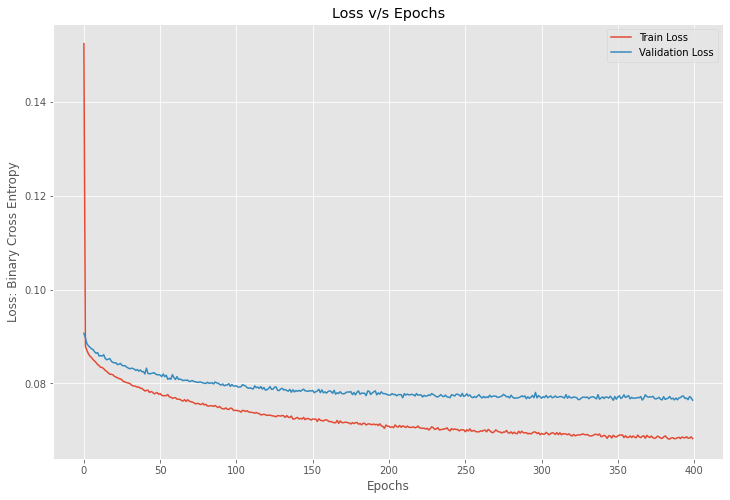

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(hist.history['loss'], label = 'Train Loss')
plt.plot(hist.history['val_loss'], label = 'Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss: Binary Cross Entropy")
plt.title("Loss v/s Epochs")
plt.legend()
plt.show()

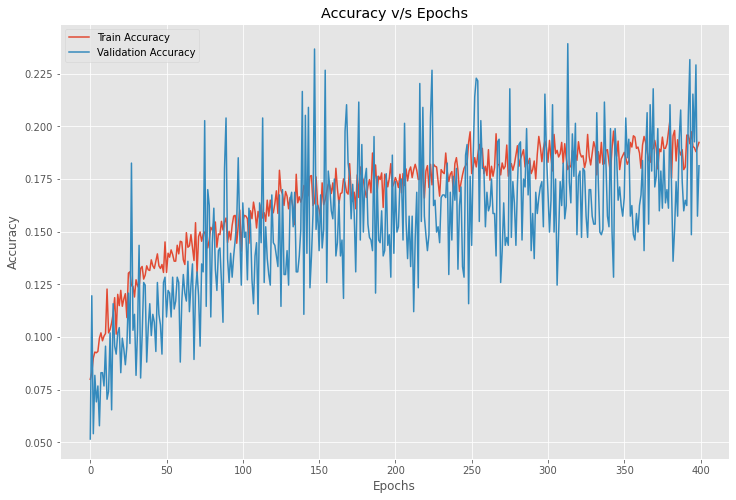

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(hist.history['accuracy'], label = 'Train Accuracy')
plt.plot(hist.history['val_accuracy'], label = 'Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy v/s Epochs")
plt.legend()
plt.show()

In [ ]:
# Save the model
model.save('BERT_model_2.h5')

In [ ]:
# Load the save model
saved_bert_model = tf.keras.models.load_model('/content/BERT_model_2.h5', custom_objects={'KerasLayer' : KerasLayer})

In [ ]:
# Test and train predictions
y_pred_bert = saved_bert_model.predict(X_test)
y_pred_bert_train = saved_bert_model.predict(X_train)

In [ ]:
# Compute train and test metrics

# 1. Train metrics
train_micro_metrics_bert, train_macro_metrics_bert = compute_metrcis(y_train, y_pred_bert_train.round(), 'BERT')

# 2. Test metrics 
test_micro_metrics_bert, test_macro_metrics_bert = compute_metrcis(y_test, y_pred_bert.round(), 'BERT')

In [ ]:
# Concatenate the results and prepare final results
train_micro_metrics_bert = train_micro_metrics_bert.add_suffix('_Train')
test_micro_metrics_bert = test_micro_metrics_bert.add_suffix('_Test')

bert_results = pd.concat((train_micro_metrics_bert, test_micro_metrics_bert), axis=1)
final_results = pd.concat((model_metrics, bert_results), axis=0).sort_values(by=['f1_Micro_Test', 'Precision_Micro_Test'], ascending=False)

In [ ]:
final_results[['f1_Micro_Test', 'Precision_Micro_Test']]

,f1_Micro_Test,Precision_Micro_Test
XGBoost,0.652174,0.853581
LightGBM,0.651584,0.761905
DecisionTree,0.591853,0.610504
RandomForest,0.537354,0.859253
LogisticRegression,0.535334,0.864317
ExtraTrees,0.532713,0.866429
ExtraTrees_Best,0.423437,0.897567
BERT,0.309743,0.751926
NaiveBayes,0.239893,0.775378


In [ ]:
# Dump the MultiLabel Binarizer Object and the tfidf vectors as well
pickle.dump(mlb, open('MultiLabelBinarizer_obj.pkl', 'wb'))
pickle.dump(tfidf, open("TFIDF_Vectors.pkl", 'wb'))

In [ ]:
# Make Prediction
test_input1 = "McDonald's serves delicious range of Burgers and wraps. They also offer cripy fries with Piri piri mix. It is an American QSR."
test_input2 = "PIND BALLUCHI is one of the most famous Punjabi, Multi Cuisine restaurant chains in India. It offers a wide variety of cuisines and dishes. It gives the feel of Punjab.Some of the most famous dishes are Butter Chicken, Chicken Tikka, Dal Makhani, Butter Naan, Sarso Da Saagi. It also offers chinese dishes like Noodles, Manchurian, Chilli Chicken and Chilli Potato. We offer dining as well as delivery service."

In [ ]:
# Performance of XGBoost Model on test_input1

prep_input1 = preprocess_text(test_input1, remove_symbols=True)
vector_input1 = tfidf.transform([prep_input1])
xgb_pred1 = xgb_clf.predict(vector_input1)
xgb_labels1 = mlb.inverse_transform(xgb_pred1)

# Performance of XGBoost Model on test_input2
prep_input2 = preprocess_text(test_input2, remove_symbols=True)
vector_input2 = tfidf.transform([prep_input2])
xgb_pred2 = xgb_clf.predict(vector_input2)
xgb_labels2 = mlb.inverse_transform(xgb_pred2)

In [ ]:
print("Cuisine Categories for test_input_1 are ", xgb_labels1[0])
print("Cuisine Categories for test_input_1 are ", xgb_labels2[0])

Cuisine Categories for test_input_1 are  ('burger', 'fast food')
Cuisine Categories for test_input_1 are  ('chinese', 'north indian')


In [ ]:
# Performance of BERT Model on test_input1
bert_predictions1 = saved_bert_model.predict([[test_input1]]).round()
bert_labels1 = mlb.inverse_transform(bert_predictions1)

# Performance of BERT Model on test_input2
bert_predictions2 = saved_bert_model.predict([test_input2]).round()
bert_labels2 = mlb.inverse_transform(bert_predictions2)

print("Cuisine Categories for test_input_1 are ", bert_labels1[0])
print("Cuisine Categories for test_input_1 are ", bert_labels2[0])

Cuisine Categories for test_input_1 are  ()
Cuisine Categories for test_input_1 are  ('asian', 'cantonese', 'hyderabadi', 'maharashtrian', 'mughlai', 'north indian', 'thai', 'turkish')
